**Transfer Learning** - the practice of re-using a trained neural network that solves a problem similar to yours, with re-training only the higher layers of network. 

Re-using the NN allows to avoid designing NN architecture from scratch. Also, training a NN on a huge corpus of data is expensive, so when you use a pre-trained model, you save time and effort of training a model from scratch. 

Transfer Learning works only for specific use cases that are common, such as image classification, image recognition, or language translation. So, the constraint is that the problem structure that you are trying to solve with the existing architecture has to remain the same, only some details can vary. 

The PyTorch framework has a number of pre-trained models available that can be used for image classification.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time

import torchvision
from torchvision import datasets, transforms

from torchvision import models # contains pretrained models

import warnings
warnings.filterwarnings('ignore')

Pre-trained models in PyTorch expect images of at least 224 * 224, pixels values be in the range [0,1] and normalized using these values: https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18

In [2]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [6]:
data_dir = '.datasets/cifar10/train'
batch_size = 8
num_workers = 2

In [7]:
trainset = torchvision.datasets.CIFAR10(root=data_dir,
                                        train=True,
                                        download= True, 
                                        transform=train_transform)

Files already downloaded and verified


In [8]:
testset = torchvision.datasets.CIFAR10(root=data_dir,
                                       train=False,
                                       download= True, 
                                       transform=test_transform)

Files already downloaded and verified


In [9]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=num_workers)


testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         num_workers=num_workers)

In [10]:
dataloaders = {
    'train': trainloader,
    'test': testloader
}

dataset_sizes = {'train': len(trainloader), 'test': len(testloader)}
dataset_sizes

{'train': 6250, 'test': 1250}

In [11]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Transfer learning
* Load the pretrained model, Resnet18
* Define parameters
* The criterion to minimize in the loss function. Given this is a classification model, we will look to minimize the cross-entropy loss
* A simple SGD optimizer with momentum which accelerate gradients vectors in the right directions and hence leads to faster converging
* Scheduler to decay Learning Rate by a factor of 0.1 every 7 epochs

In [12]:
# We will use Resnet18 image classification model
model = models.resnet18(pretrained=True)

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Notice that out_features=1000 
# so, we will need to change the last linear layer (CIFAR10 has only 10 classes, not 1000)

In [15]:
# Let's freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

In [16]:
# Now, when the weights of layers are frozen, let's replace the last linear layer
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 10) # replacing the last layer: the output_size=number of output labels in our data

In [17]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    
print(device)

cpu


In [18]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Notice that out_features=10 now :-) 

### Training the model

**Define training and test phase**
* scheduler.step() will set up the scheduler for each step in order to decay the learning rate
* Each epoch has a training and test phase
* model.train() will set the pre-trained model into training mode. This is only available for pre-trained models
* running_loss will keep track of the loss at each iteration
* running_corrects keeps a count of the number of correct predictions which will be used to calculate the accuracy of the model 
* outputs is the list probabilities for each possible label for the batch of images (which are the inputs). We use torch.max() to get the index of the highest probability label for each image in the batch

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        step = 0
        
        for phase in ['train', 'test']:
            
            if phase == 'train':
                scheduler.step()
                model.train(True)  
                # Set model to training mode
                
            else:
                model.train(False)  
                # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                step += 1
                if step % 500 == 0:
                    print('Epoch: {} Loss: {:.4f},  Step: {}'.format(epoch, loss.item(), step))
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double()/ (dataset_sizes[phase]*batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f} '.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    print('Training complete')
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [22]:
model = train_model(model, criterion, optimizer_ft, 
                    exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
Epoch: 0 Loss: 1.1954,  Step: 500
Epoch: 0 Loss: 1.2095,  Step: 1000
Epoch: 0 Loss: 1.6848,  Step: 1500
Epoch: 0 Loss: 1.3710,  Step: 2000
Epoch: 0 Loss: 1.0250,  Step: 2500
Epoch: 0 Loss: 2.2215,  Step: 3000
Epoch: 0 Loss: 2.1634,  Step: 3500
Epoch: 0 Loss: 1.4578,  Step: 4000
Epoch: 0 Loss: 1.7049,  Step: 4500
Epoch: 0 Loss: 1.7396,  Step: 5000
Epoch: 0 Loss: 2.0943,  Step: 5500
Epoch: 0 Loss: 1.9154,  Step: 6000
train Loss: 11.7373 Acc: 0.4931 
Epoch: 0 Loss: 0.6036,  Step: 6500
Epoch: 0 Loss: 0.6217,  Step: 7000
Epoch: 0 Loss: 0.4142,  Step: 7500
test Loss: 6.4710 Acc: 0.7198 

Epoch 1/2
----------
Epoch: 1 Loss: 1.6567,  Step: 500
Epoch: 1 Loss: 1.2565,  Step: 1000
Epoch: 1 Loss: 0.9876,  Step: 1500
Epoch: 1 Loss: 0.9381,  Step: 2000
Epoch: 1 Loss: 2.1526,  Step: 2500
Epoch: 1 Loss: 2.1987,  Step: 3000
Epoch: 1 Loss: 1.6583,  Step: 3500
Epoch: 1 Loss: 1.6126,  Step: 4000
Epoch: 1 Loss: 1.0705,  Step: 4500
Epoch: 1 Loss: 1.7586,  Step: 5000
Epoch: 1 Loss: 1.715

### Using the trained model for prediction

In [23]:
# helper function
def imshow(inp, title):
    
    inp = inp.cpu().numpy().transpose((1,2,0))
    inp = inp * std + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)

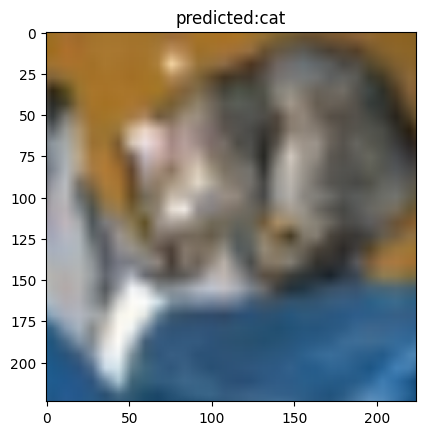

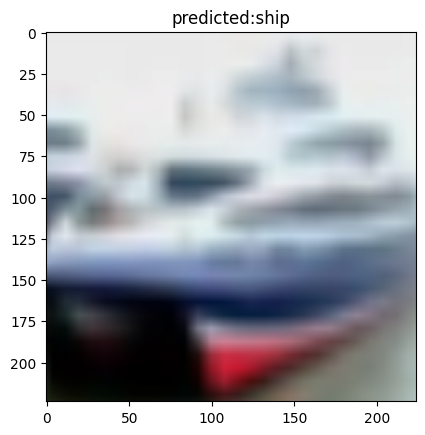

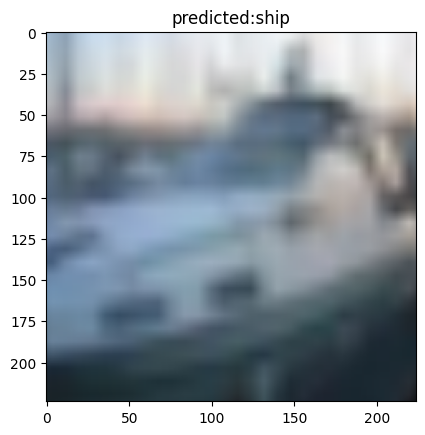

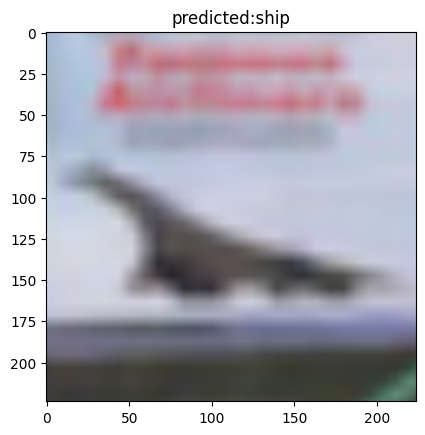

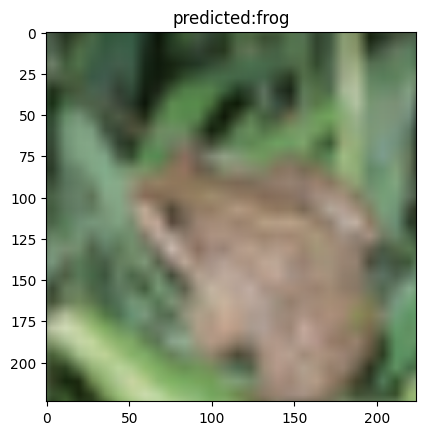

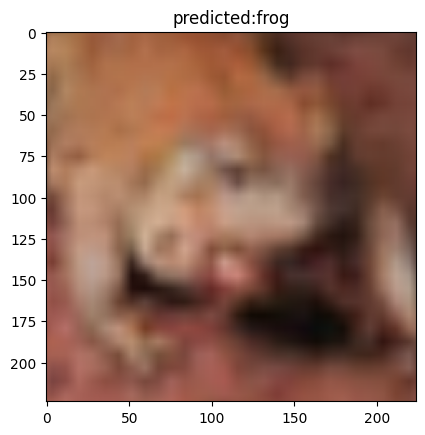

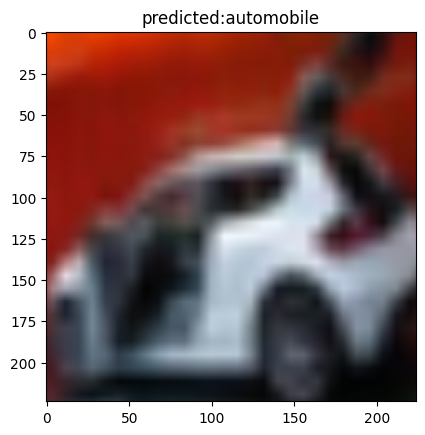

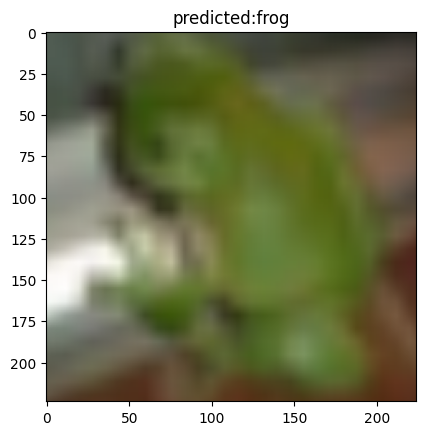

In [24]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    inputs, labels = inputs.to(device), labels.to(device)
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])